## Instructions

- Follow the installation instructions in the readme file
- Answer the questions in this notebook
- Once your work is finished: restart the kernel, run all cells in order and check that the outputs are correct.
- Send your completed notebook to `remy.degenne@inria.fr` with email title `SL_TP2_NAME1_NAME2` (or `SL_TP2_NAME` if you work alone).

**Deadline: Wednesday, January 10, 15:00 CET**.

If you don't want to use a local installation, you can try Google Colab:

<a target="_blank" href="https://colab.research.google.com/github/RemyDegenne/remydegenne.github.io/blob/master/docs/SL_2023/TD0_QLearning.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [36]:
# This cell is setting up google colab. Ignore it if you work locally.
if 'google.colab' in str(get_ipython()):
  print("Installing packages, please wait a few moments. Restart the runtime after the installation.")
  # install rlberry library
  !pip install scipy rlberry

# Small MDP with unknown dynamics: TD(0) and Q-Learing

**The problem is the same as the last practical session: store management. The first few cells set up the environment and provide helpful tools like a policy iteration algorithm to compute the optimal policy if the MDP is known.**

**The goal of this practical session is to implement algorithms for finding the optimal policy when the MDP is unknown.**


You own a bike store. During week $t$, the (random) demand is $D_t$ units. 
On Monday morning you may choose to command $A_t$ additional units: they are delivered immediately before the shop opens. For each week:

  * Maintenance cost: $h$ per unit in stock left from the previous week (no maintenance is needed for newly commanded items)
  * Command cost: $c$ for each unit ordered + $c_0$ per command
  * Sales profit: $p$ per unit sold
  * Constraint: 
    - your warehouse has a maximal capacity of $M$ unit (any additionnal bike gets stolen)
    - you cannot sell bikes that you don't have in stock


* State: number of bikes in stock left from the last week => state space $\mathcal{S} = \{0,\dots, M\}$
* Action: number of bikes commanded at the beginning of the week => action space $\mathcal{A} = \{0, \dots ,M\}$ 
* Reward = balance of the week: if you command $a_t$ bikes,
$$r_t = -c_0 \mathbb{1}_{(a_t >0)}- c \times a_t - h\times s_t + p \times \min(D_t, s_t+a_t, M)$$
* Transitions: you end the week with the number of bikes $$s_{t+1} = \max\big(0, \min(M, s_t + a_t)  - D_t \big)$$ 

Our goal is to maximize the discounted sum of rewards, starting from an initial stock $s_1$, that is to find a policy whose value is 
$$V^*(s_1) = \max_{\pi}\mathbb{E}_{\pi}\left[\sum_{s=1}^{\infty} \gamma^{s-1}r_s \right].$$

In [1]:
import numpy as np
import random as rd
import gymnasium as gym
from matplotlib import pyplot as plt
import time 

### Problem parameters

In [2]:
M = 15 # stock capacity
h = 0.3 # maintenance cost (per unit)
c = 0.5 # ordering cost (per unit)
c0 = 0.3 # fix delivery cost per command
p = 1 # selling price (per unit)

### Specifying the demand distribution 

As an example of demand distribution, we choose a (truncated) geometric distribution, for which 
$$\mathbb{P}(D_t = m) = q(1-q)^m \ \ \forall m \in \{0,\dots,M-1\}$$
and $\mathbb{P}(D_t = M) = 1 - \sum_{m=0}^{M-1}\mathbb{P}(D_t = m)$. We provide below a function that simulate the demand. 

In [3]:
# demand distribution (truncated geometric with parameter q)
q = 0.1
pdem = np.array([q*(1-q)**m for m in range(M+1)])
pdem[M] = pdem[M]+1-np.sum(pdem)

print("the average demand is ",np.sum([m*pdem[m] for m in range(M+1)]))

def SimuDemand(pdem): 
    cpdem = np.cumsum(pdem)
    i=0
    u = rd.random()
    while (u >cpdem[i]):
        i = i+1
    return i 

print("a simulated demand is ",SimuDemand(pdem))

the average demand is  7.1469798111481575
a simulated demand is  3


### Encoding the MDP as a gymnasium environment

This is just a  toy example on how to create a gymnasium environement. 

Note that our environement is an example of tabular MDP for which the transition probabilities $P(s'|s,a)$ and the mean rewards $r(s,a)$ can actually be computed in closed form. Therefore we provide the transitions $(P)$ and mean rewards $(r)$ as attributes of the class. 

In [4]:
def nextstate(s,a,d,M):
    # computes the next state if the demand is d
    return max(0,min(M,s+a) -d)

def nextreward(s,a,d,M,c,c0,h,p):
    # computes the reward if the demand is d
    rew = -c*a - h*s + p*min(M,d,s+a)
    if (a>0):
        rew = rew - c0
    return rew

class StoreManagement(gym.Env):
    """
    Retail Store Management environment
    The environment defines which actions can be taken at which point and
    when the agent receives which reward.
    """
    def __init__(self,FirstState,M=15,h=0.3,c=0.5,c0=0.3,p=1,q=0.1):
        
        # General variables defining the environment
        self.Stock_Capacity = M
        self.Maintenance_Cost = h
        self.Order_Cost = c 
        self.Delivery_Cost = c0
        self.Selling_Price = p
        pdem = np.array([q*(1-q)**m for m in range(M+1)])
        pdem[M] = pdem[M]+1-np.sum(pdem)
        self.Demand_Distribution = pdem
        
        # Define the action space
        self.action_space = gym.spaces.Discrete(self.Stock_Capacity+1)

        # Define the state space (state space = observation space in this example)
        self.observation_space = gym.spaces.Discrete(self.Stock_Capacity+1)

        # current time step
        self.curr_step = -1 # 
        
        # initial state
        self.state = FirstState

        # computation of the MDP parameters
        P = np.zeros((M+1,M+1,M+1)) # P[s,a,s'] = p(s' | s,a) 
        r = np.zeros((M+1,M+1)) # r[s,a] = average reward received in state s when playing action a
        ## iteration over all possible states, actions, and possible demand values
        for a in range(M+1):
            for s in range(M+1):
                for d in range(M+1):
                    # next state and reward with demand d
                    ns = max(0,min(M,s+a) -d)
                    reward = -c*a - h*s+p*min(M,d,s+a)
                    if (a>0):
                        reward = reward - c0
                    P[s,a,ns] += pdem[d]
                    r[s,a] += pdem[d] * reward
        self.P = P # P[s,a,ns] = P(ns | s,a)
        self.r = r # r[s,a] = r(s,a)

    def step(self, action):
        """
        simulates a transition following an action in the current state
        action : int
        """
        self.curr_step += 1
        # simulate the demand 
        Demand = SimuDemand(self.Demand_Distribution)
        # compute the reward
        reward = nextreward(self.state,action,Demand,self.Stock_Capacity,self.Order_Cost,self.Delivery_Cost,self.Maintenance_Cost,self.Selling_Price)
        # compute the next state 
        self.state = nextstate(self.state,action,Demand,self.Stock_Capacity)
        # return 5 elements: observation / reward / termination? / truncation ? / information  
        return self.state, reward, False, False,{}

    def reset(self,InitialStock):
        """
        Reset the state of the environment and returns an initial observation.
        """
        self.curr_step = -1
        self.state = InitialStock
    
    def _render(self, mode='human'):
        """optional visualization of the interaction: none here"""
        return


### A function that simulates a trajectory under a policy Pi starting from some state $s_0$

In [5]:
def SimulateTrajectory(T,Pi,s0):
    """return a vector of T successive states and a vector of T successive rewards"""
    Rewards = np.zeros(T)
    States = np.zeros(T)
    env=StoreManagement(s0)
    for t in range(T):
        States[t]=env.state
        action=Pi(env.state)
        state,rew,_,_,_=env.step(action)
        Rewards[t]=rew
    return States,Rewards

### Some simple policies

In [6]:
def PiUniform(s):
    # pick uniformly at random in {0,1,...,M-s}
    x = rd.sample(range(M+1-s),1)
    return s+x[0]

def PiConstant(s,c=3):
    # oder a constant number of c bikes 
    return min(c,M-s)

def PiThreshold(s,m1=4,m2=10):
    # if less than m1 bikes in stock, refill it up to m2
    action = 0
    if (s <=m1):
        action = (m2-s)
    return action

### Policy evaluation using the matrix inversion technique

Since the MDP is small, if we know the reward and transition distributions we can compute the value of a policy with the matrix inversion method.

In [7]:
env = StoreManagement(0,M=15,h=0.3,c=0.5,c0=0.3,p=1,q=0.1)
s1 = 10 # initial stock 
gamma = 0.97 # discount factor 

# MDP parameters
P = env.P # P[s,a,s'] = p(s' | s,a) 
r = env.r # r[s,a] = average reward received in state s when playing action a

In [8]:
 def EvaluatePolicy(Pi):
    # input: function (could also be vector as we can only use this method for deterministic policies)
    r_Pi=np.zeros((M+1,1))
    P_Pi=np.zeros((M+1,M+1))
    for s in range(M+1):
        P_Pi[s,:]=P[s,Pi(s),:] # matrix P^\pi
        r_Pi[s]=r[s,Pi(s)] # vector r^\pi
    V = np.linalg.inv(np.eye(M+1) - gamma * P_Pi) @ r_Pi
    return V.transpose()[0]

Values = EvaluatePolicy(PiThreshold)
print(Values)

[48.73499347 48.93499347 49.13499347 49.33499347 49.53499347 49.71122352
 50.04440882 50.34326461 50.60790492 50.83844345 51.03499347 51.19766791
 51.32657931 51.42183984 51.48356131 51.51185512]


### Policy iteration

If the MDP is known, we can compute the optimal policy with policy iteration.

In [9]:
# policy improvement
def Improve(V):
    '''computes the Q table associated to V and 
    return Pi=greedy(V)=greedy(Q) as well as max_{a} Q[s,a]'''
    Pi = np.zeros(M+1) # improved policy 
    newV = np.zeros(M+1)
    # compute the Q table 
    Q = np.zeros((M+1,M+1))
    for s in range(M+1):
        for a in range(M+1):
            Q[s,a]=r[s,a]+gamma*np.sum([P[s,a,ns]*V[ns] for ns in range(M+1)])
        # improvement (greedy policy wrt to Q)
        pi = np.argmax(Q[s,:])
        Pi[s]=pi
        newV[s]=Q[s,pi]
        Pi=Pi.astype(int)
    return Pi,newV

def PolicyIteration():
    # initalization 
    Pi = np.zeros(M+1)
    V = np.zeros(M+1)
    # new policy 
    newPi = np.random.randint(M+1,size=M+1) 
    newPi[0]=1
    nIt = 0 
    while (not (Pi==newPi).all()):
        nIt +=1 
        Pi = np.copy(newPi)
        # evaluate the policy (transformed into a function)
        def PiFun(s):
            return Pi[s]
        V = EvaluatePolicy(PiFun)
        newPi,x = Improve(V)
    return Pi,V,nIt  # Policy, value, number of iterations

In [10]:
start = time.time()
Pi2,V2,nIt2 = PolicyIteration()
elapsed = time.time()-start

print("Optimal policy is",Pi2,"with value ",V2," in ",nIt2," iterations and t=",elapsed," seconds")

Optimal policy is [9 8 7 6 5 4 0 0 0 0 0 0 0 0 0 0] with value  [48.86867719 49.06867719 49.26867719 49.46867719 49.66867719 49.86867719
 50.17594925 50.47436803 50.73857278 50.96867719 51.16479455 51.32703775
 51.45551935 51.55035152 51.61164603 51.63951432]  in  5  iterations and t= 0.02218484878540039  seconds


# Learning in a MDP with unknown dynamics

Now we consider reinforcement learning algorithms, who cannot make use of the knowledge of P and R, but can only simulate transistions.

## Stochastic Approximation for Policy Evaluation: TD(0)

TD(0) is an algorithm for policy evaluation: given a policy, we want to compute an accurate estimate of its value V.
It can be seen as parallel Robbins-Monro algorithms, one per state.

The algorithm starts from a random value vector V and a random state s0, then performs T transitions, taking actions according to the policy we want to evaluate. At each transition (from $s$ to $s'$, with reward $r$), it increments the visitation count $N(s)$ of the current state, then performs a Robbins-Monro update

$V(s) \leftarrow V(s) + \alpha_{N(s)}(r + \gamma V(s') - V(s))$

See lecture 3 for the full pseudo-code.

**Implement TD(0) with step size $\alpha_{N(s)} = 1/\sqrt{N(s)}$**


In [11]:
def TD0(Pi, T):  # Pi: policy to be evaluated, T: number of iterations
    V = np.random.rand(M+1) # V[s] = estimated value of each state under policy pi
    N = np.zeros(M+1) # N[s] =number of visits to state s in the loop
    s0 = np.random.randint(M+1)
    env = StoreManagement(s0)
    for t in range(T):
        s = env.state
        N[s] += 1
        action = Pi(s)
        state, rew, _, _, _ = env.step(action)
        V[s] = V[s] + 1/np.sqrt(N[s]) * (rew + gamma * V[state] - V[s])
    return(V)

**Use TD(0) to compute the value of one of the simple policies defined in the introduction.**

To check that value, plot the error between the estimated value of TD(0) and the value computed by matrix inversion $\Vert V_{TD(0)} - V_{MI} \Vert_\infty$, as a function of the number of transitions $T$ used in TD(0).

Comment on the number of iterations needed to have a good estimate.

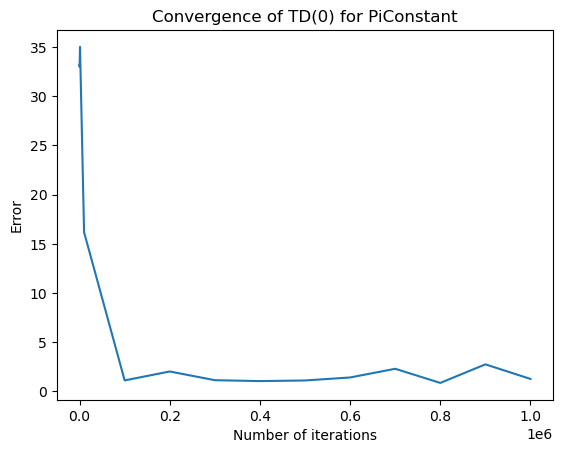

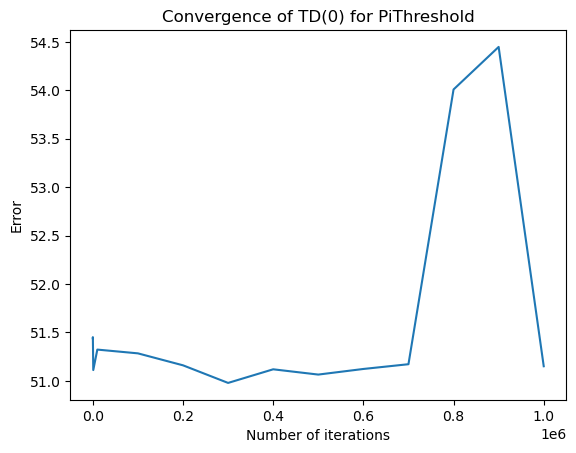

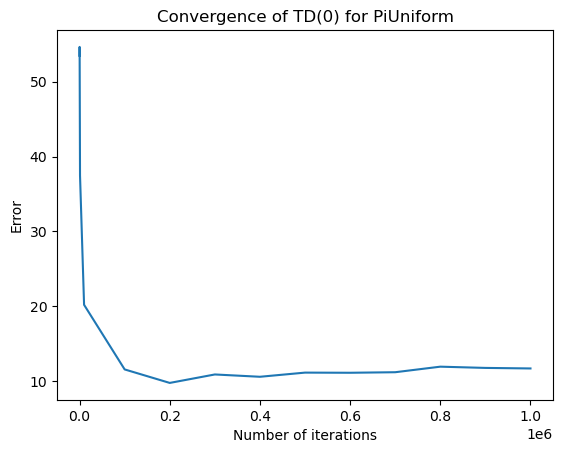

In [12]:

v_mi=EvaluatePolicy(PiConstant)
test_list = [10, 100, 1000, 10000, 100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000,900000,1000000]
diff=[]
for k in test_list:
    v=TD0(PiConstant,k)    
    diff.append(np.linalg.norm(v-v_mi,ord=np.inf))

plt.plot(test_list,diff)
plt.xlabel("Number of iterations")
plt.ylabel("Error")
plt.title("Convergence of TD(0) for PiConstant")

plt.show()
diff2=[]

v_mi=EvaluatePolicy(PiThreshold)
for k in test_list:
    v=TD0(PiThreshold,k)    
    diff2.append(np.linalg.norm(v-v_mi,ord=np.inf))

plt.plot(test_list,diff2)
plt.xlabel("Number of iterations")
plt.ylabel("Error")
plt.title("Convergence of TD(0) for PiThreshold")

plt.show()
diff3=[]

v_mi=EvaluatePolicy(PiUniform)
for k in test_list:
    v=TD0(PiUniform,k)    
    diff3.append(np.linalg.norm(v-v_mi,ord=np.inf))


plt.plot(test_list,diff3)
plt.xlabel("Number of iterations")
plt.ylabel("Error")
plt.title("Convergence of TD(0) for PiUniform")

plt.show()



**Compare TD(0) with different updates for $\alpha_{N(s)}$**.

What exponents $\beta$ are allowed by the theory for $\alpha_{N(s)} = 1/N(s)^\beta$ ?

You used $\beta = 1/2$ above. Now try $\beta = 1$ as well as $\beta = 0$ ($\alpha$ constant). What works best? (look at different values of T)


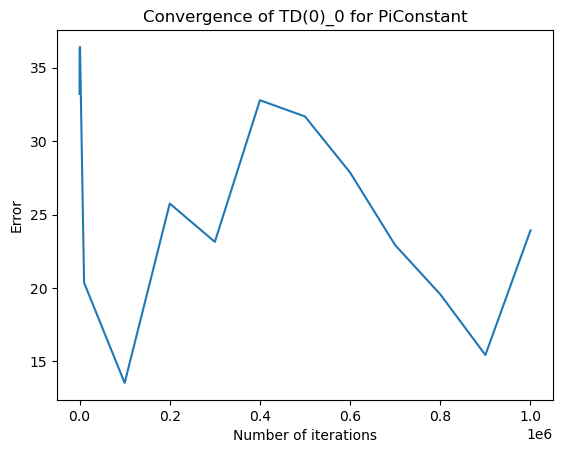

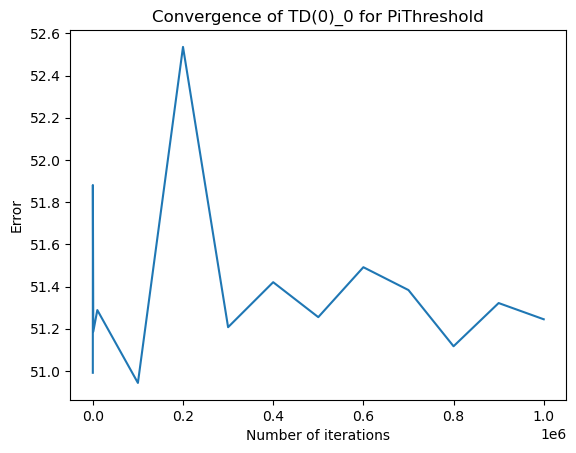

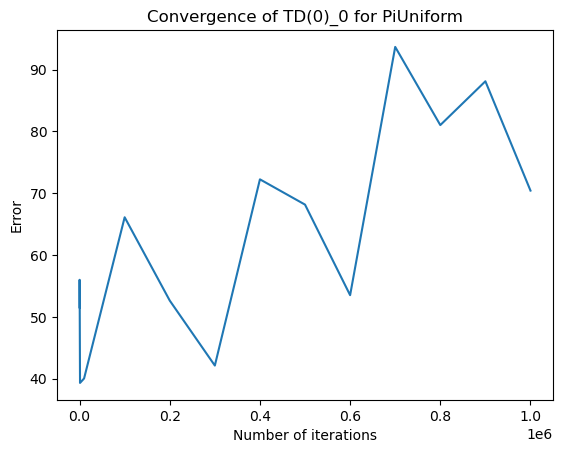

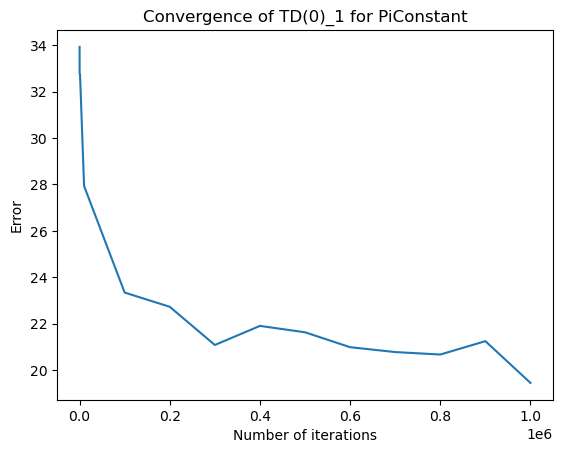

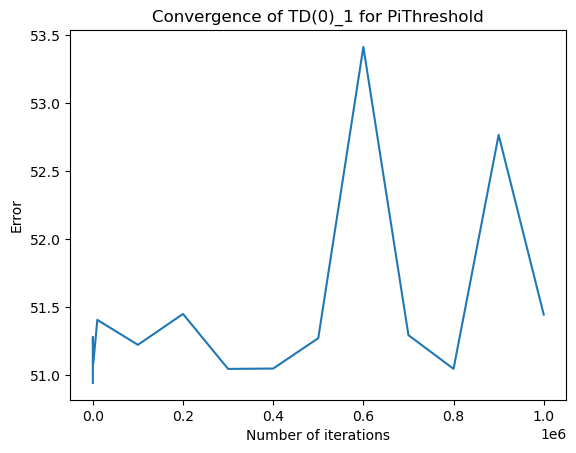

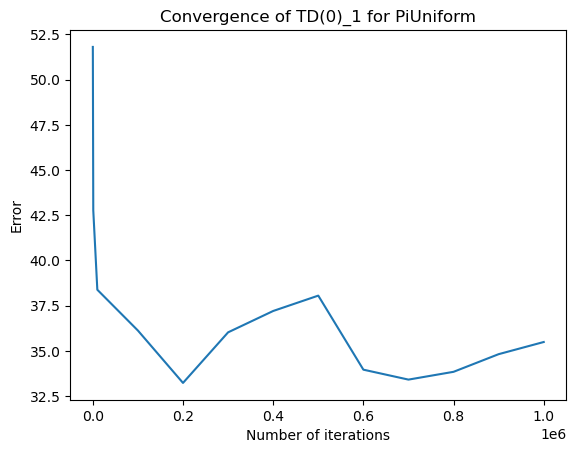

In [13]:
def TD0_0(Pi, T):  # Pi: policy to be evaluated, T: number of iterations
    V = np.random.rand(M+1) # V[s] = estimated value of each state under policy pi
    N = np.zeros(M+1) # N[s] =number of visits to state s in the loop
    s0 = np.random.randint(M+1)
    env = StoreManagement(s0)
    for t in range(T):
        s = env.state
        N[s] += 1
        action = Pi(s)
        state, rew, _, _, _ = env.step(action)
        V[s] = V[s] + (rew + gamma * V[state] - V[s])
    return(V)

def TD0_1(Pi, T):  # Pi: policy to be evaluated, T: number of iterations
    V = np.random.rand(M+1) # V[s] = estimated value of each state under policy pi
    N = np.zeros(M+1) # N[s] =number of visits to state s in the loop
    s0 = np.random.randint(M+1)
    env = StoreManagement(s0)
    for t in range(T):
        s = env.state
        N[s] += 1
        action = Pi(s)
        state, rew, _, _, _ = env.step(action)
        V[s] = V[s] + 1/N[s] * (rew + gamma * V[state] - V[s])
    return(V)


v_mi=EvaluatePolicy(PiConstant)
test_list = [10, 100, 1000, 10000, 100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000,900000,1000000]
diff=[]
for k in test_list:
    v=TD0_0(PiConstant,k)    
    diff.append(np.linalg.norm(v-v_mi,ord=np.inf))


plt.plot(test_list,diff)
plt.xlabel("Number of iterations")
plt.ylabel("Error")
plt.title("Convergence of TD(0)_0 for PiConstant")

plt.show()
diff2=[]

v_mi=EvaluatePolicy(PiThreshold)
for k in test_list:
    v=TD0_0(PiThreshold,k)    
    diff2.append(np.linalg.norm(v-v_mi,ord=np.inf))

plt.plot(test_list,diff2)
plt.xlabel("Number of iterations")
plt.ylabel("Error")
plt.title("Convergence of TD(0)_0 for PiThreshold")

plt.show()
diff3=[]

v_mi=EvaluatePolicy(PiUniform)
for k in test_list:
    v=TD0_0(PiUniform,k)    
    diff3.append(np.linalg.norm(v-v_mi,ord=np.inf))



plt.plot(test_list,diff3)
plt.xlabel("Number of iterations")
plt.ylabel("Error")
plt.title("Convergence of TD(0)_0 for PiUniform")

plt.show()

v_mi=EvaluatePolicy(PiConstant)
diff=[]
for k in test_list:
    v=TD0_1(PiConstant,k)    
    diff.append(np.linalg.norm(v-v_mi,ord=np.inf))


plt.plot(test_list,diff)
plt.xlabel("Number of iterations")
plt.ylabel("Error")
plt.title("Convergence of TD(0)_1 for PiConstant")

plt.show()
diff2=[]

v_mi=EvaluatePolicy(PiThreshold)
for k in test_list:
    v=TD0_1(PiThreshold,k)    
    diff2.append(np.linalg.norm(v-v_mi,ord=np.inf))

plt.plot(test_list,diff2)
plt.xlabel("Number of iterations")
plt.ylabel("Error")
plt.title("Convergence of TD(0)_1 for PiThreshold")

plt.show()
diff3=[]

v_mi=EvaluatePolicy(PiUniform)
for k in test_list:
    v=TD0_1(PiUniform,k)    
    diff3.append(np.linalg.norm(v-v_mi,ord=np.inf))



plt.plot(test_list,diff3)
plt.xlabel("Number of iterations")
plt.ylabel("Error")
plt.title("Convergence of TD(0)_1 for PiUniform")

plt.show()



## Every-visit Monte-Carlo, or TD(1)

Every-visit Monte-Carlo starts from an arbitrary value vector. At each iteration, it generates a trajectory of length $H$ from a random state $s_1$. After that trajectory is done, it updates the value of each state visited $s_k$ by

$V(s_k) \leftarrow V(s_k) + \alpha_{N(s_k)}(\sum_{t=k}^{H}\gamma^{t - k} r_k - V(s_k))$

(implementation hint: start from the last state, and go backwards until $s_1$)

See lecture 3 for more details.

**Implement every-visit Monte-Carlo and compare the computed value to the value returned by policy iteration**. Vary the number of trajectories and the trajectory length.

In [14]:
def TD1(Pi, H, T):  # Pi: policy to be evaluated, H: number of iterations in a trajectory, T: number of trajectories
    V = np.random.rand(M+1) # V[s] = estimated value of each state under policy pi
    N = np.zeros(M+1) # N[s] =number of visits to state s in the loop
    for t in range(T):
        s0 = np.random.randint(M+1)
        env = StoreManagement(s0)
        s = env.state
        for h in range(H):
            N[s] += 1
            action = Pi(s)
            state, rew, _, _, _ = env.step(action)
            V[s] = V[s] + 1/np.sqrt(N[s]) * (rew + gamma * V[state] - V[s])
            s = state
    return(V)

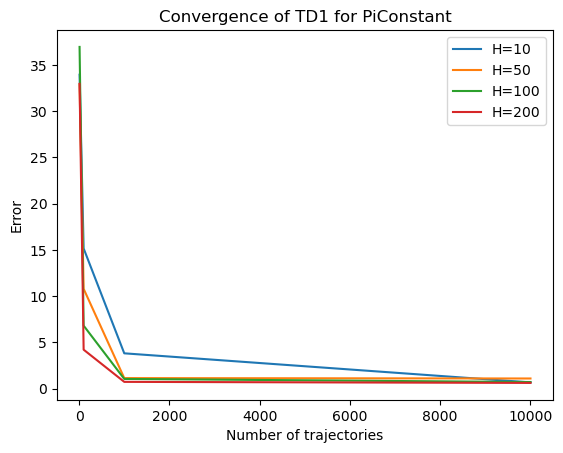

In [15]:

H=[10,50,100,200]
T=[10,10**2,10**3,10**4]
V_td1=[TD1(PiConstant, h, t) for h in H for t in T]
V_mi=EvaluatePolicy(PiConstant)
diff=[]
for v in V_td1:
    diff.append(np.linalg.norm(v-V_mi,ord=np.inf)) #c'était déjà bon sans le inf

#plot for each value of H, the convergence of TD1 as a function of T
for i in range(len(H)):
    plt.plot(T,diff[i*len(T):(i+1)*len(T)],label="H="+str(H[i]))
plt.xlabel("Number of trajectories")
plt.ylabel("Error")
plt.title("Convergence of TD1 for PiConstant")
plt.legend()
plt.show()



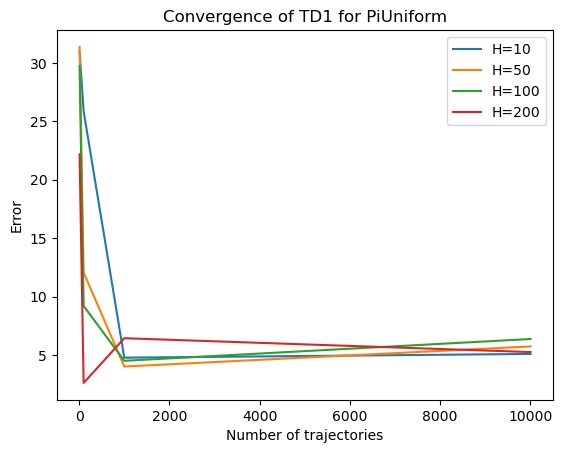

In [16]:

H=[10,50,100,200]
T=[10,10**2,10**3,10**4]
V_td1=[TD1(PiUniform, h, t) for h in H for t in T]
V_mi=EvaluatePolicy(PiUniform)
diff=[]
for v in V_td1:
    diff.append(np.linalg.norm(v-V_mi,ord=np.inf))

#plot for each value of H, the convergence of TD1 as a function of T
for i in range(len(H)):
    plt.plot(T,diff[i*len(T):(i+1)*len(T)],label="H="+str(H[i]))
plt.xlabel("Number of trajectories")
plt.ylabel("Error")
plt.title("Convergence of TD1 for PiUniform")
plt.legend()
plt.show()



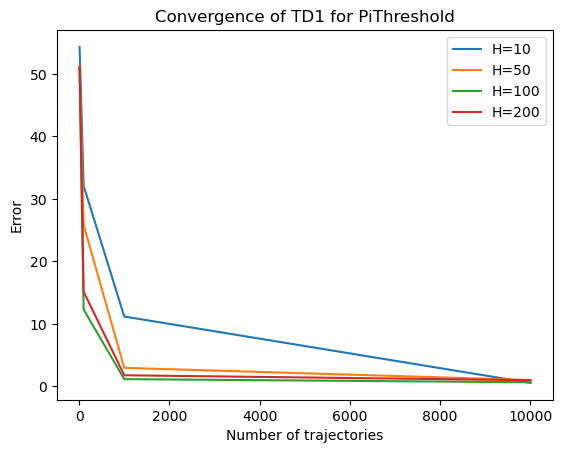

In [17]:

H=[10,50,100,200]
T=[10,10**2,10**3,10**4]
V_td1=[TD1(PiThreshold, h, t) for h in H for t in T]
V_mi=EvaluatePolicy(PiThreshold)
diff=[]
for v in V_td1:
    diff.append(np.linalg.norm(v-V_mi,ord=np.inf))

#plot for each value of H, the convergence of TD1 as a function of T
for i in range(len(H)):
    plt.plot(T,diff[i*len(T):(i+1)*len(T)],label="H="+str(H[i]))
plt.xlabel("Number of trajectories")
plt.ylabel("Error")
plt.title("Convergence of TD1 for PiThreshold")
plt.legend()
plt.show()



# Computing the optimal policy: Q-learning

Q-learning does Robbins-Monro updates on all state-action pairs in order to estimate the optimal Q-value $Q^\star$.
Then once $Q^\star$ is well estimated, Q-learning returns the associated greedy policy. The update after observing a transition from state $s$ and action $a$ to a state $s'$ with reward $r$ is

$Q(s, a) \leftarrow Q(s, a) + \alpha_{N(s,a)}(r + \gamma \max_b Q(s', b) - Q(s, a))$

See lecture 3 for a detailed pseudo-code.

**Implement Q-learning**

Take inspiration from your TD(0) code. For the behavior policy, use $\varepsilon$-greedy: with probability $1 - \varepsilon$, take the greedy(Q) action, and with probability $\varepsilon$, take a random action.

In [28]:
def q_learning(T,q0,eps):
    Q = q0
    N = np.zeros((M+1,M+1))
    s0 = np.random.randint(M+1)
    env = StoreManagement(s0)
    s = env.state
    for t in range(T):
        if (rd.random() < eps):
            a = rd.sample(range(M+1),1)[0]
        else:
            a = np.argmax(Q[s,:])
        
        N[s,a] += 1

        state, rew, _, _, _ = env.step(a)
        Q[s,a] = Q[s,a] + 1/ N[s,a]  * (rew + gamma * np.max(Q[state,:]) - Q[s,a])
        s = state
    pi=np.argmax(Q,axis=1)
    return Q,pi

**Compare the policy computed by Q-learning to the optimal policy (computed by policy iteration, for example)**

Look at how the Q-learning policy improves with the number of transitions (with plots). Comment on the number necessary to get a policy with a good value, and on the number needed to obtain the exact optimal policy.

Warning: Q-learning might need a very long time to get the exact policy (a large number of iteration, which might take very long depending on your hardware). It is fine if you don't answer that last question exactly.

[14  8  8  3  6  6  3 13  0 15 10  2 12  0  3 15]
[ 4 10  8 15  6 10  9  2  3 13 10  2 12  0  0 12]
[ 8  2  7 12  6  1  3  2  1  5  0  2  4  0  0  4]
[ 8  3  2  5  8  2  2  5  2  2  2  4  3 11  0  6]
[12  7  9  6  0  1  0  2  0  1  0  1  0  1  0  0]
[9 8 8 8 4 0 0 0 0 0 2 0 0 1 0 0]
[10  7  7  7  5  5  0  0  0  0  0  0  0  0  0  0]
[15.0, 13.0, 6.0, 11.0, 5.0, 4.0, 1.0]


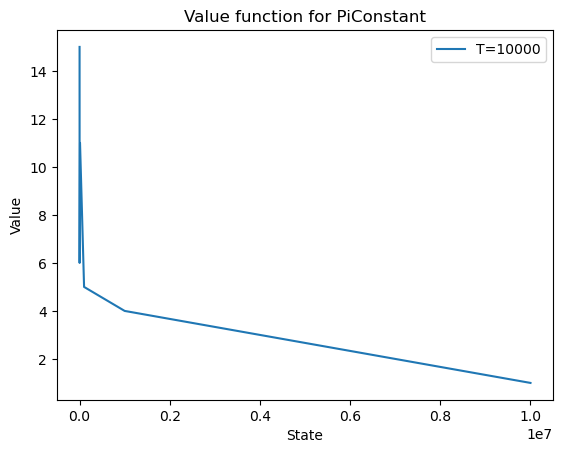

In [36]:
q0 = np.random.rand(M+1,M+1)
T_list=[10**1,10**2,10**3,10**4,10**5,10**6,10**7]

q_list=[]
pi_list=[]
for t in T_list:
    q,pi=q_learning(t,q0,0.1)
    q_list.append(q)
    pi_list.append(pi)
z=[np.linalg.norm(pi_list[i]-Pi_IP,ord=np.inf) for i in range(len(T_list))]
print(z)
Pi_IP, V_IP, nIt_IP = PolicyIteration()

plt.plot(T_list,z,label="T="+str(T_list[i]))
plt.xlabel("State")
plt.ylabel("Value")
plt.title("Value function for PiConstant")
plt.legend()
plt.show()



**Optional: investigate the influence of $\varepsilon$ in the $\varepsilon$-greedy behavior policy. Experiment with other heuristics for the behavior policy.**

[11  9  7  7  5  5  0  4  0  0  0  0  0  0  0  0]
[11  9 15  7  5  3  0  0  0  0  0  0  0  0  0  0]
[11  9 15  7  5  5  0  0  0  0  2  0  0  0  0  0]
[15  9 15  7  5  5  0  0  0  0  2  0  0  0  0  0]
[ 9  8 15  7  5  5  0  0  0  0  2  0  0  0  0  0]
[15  8 15  7  5  5  4  0  0  0  6  2  0  0  0  0]
[ 4 12  7  6  5  9  4  0  0  0  6  1  0  0  0  0]
[ 6 12  7  8  5  9 12  0  0  9  6  1  0 14  8  0]
[15  7 14 11 11  9  0 11  0  9  6  1  0 14  0  0]
[ 9  2 14 10 13  7  4 11  5  4  6  5  0 14  0 14]
[9 7 4 9 9 2 1 0 2 6 6 1 0 8 4 0]
[ 8  3  4  9  2 12  4  5  7  1 10  1  0  2  2  0]
[ 9 11  4  0  3  1  6 10  5  2  0  3  1  0  2  0]
[12 12  6  3  4  4  8  3  0  5  9  2  1  0  2  3]
[ 7 13 10  7  4 13  6  6  2  1  2  0  0  2  2  2]
[12 13 11  4  4  0  6  1  0  1  0  0  1  0  0  3]
[11  6  3  8  7  1  4  0  3  0  1  1  1  3  1  3]
[ 9  9 11  3 12  5  1  5  0  1  3  0  0  3  2  1]
[9 9 7 4 1 2 4 4 4 2 1 2 0 0 1 0]
[ 7 11  9 12  2  3  2  4  1  3  0  0  1  0  0  0]
[ 9  7 10  6  5  6  4  1  0  0  

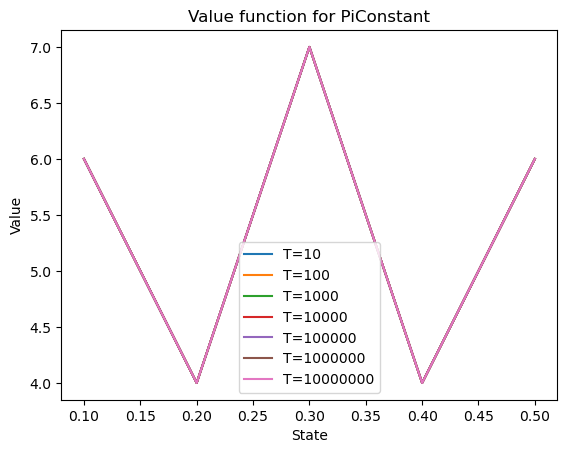

In [37]:
eps=[0.1,0.2,0.3,0.4,0.5]
q_list=[]
pi_list=[]
for t in T_list:
    for e in eps:
        q,pi=q_learning(t,q0,e)
        q_list.append(q)
        pi_list.append(pi)

z=[np.linalg.norm(pi_list[i]-Pi_IP,ord=np.inf) for i in range(len(T_list)*len(eps))]

for e in range(len(eps)):
    z2=[z[i*len(eps)+e] for i in range(len(T_list))]
    plt.plot(T_list,z2,label="eps="+str(eps[e]))
plt.xlabel("State")
plt.ylabel("Value")
plt.title("Value function for PiConstant")
plt.legend()

plt.show()


